In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'C:/Users/HP/Downloads/lfw_today'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


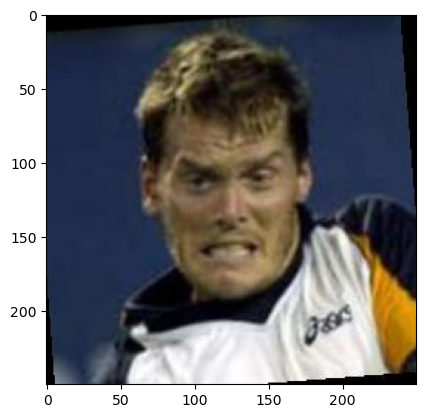

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

Variational Autoencoders (VAEs) and traditional Autoencoders (AEs) are both types of neural network architectures used for unsupervised learning and dimensionality reduction. Mainly we can see differences in 3 ways. Those are as below:

Difference in Applications:
--------------------------------------
Traditional autoencoders are primarily used for dimensionality reduction, data denoising, and feature learning. They compress the input data into a latent space representation and then reconstruct the input from this representation.

Whereas VAEs not only compress input data into a latent space but also model the probability distribution of the latent space, enabling them to generate new data points. VAEs are particularly powerful for generating new data samples. They are used in various generative tasks such as image generation, anomaly detection etc.,

Difference in Architecture:
--------------------------------------
Traditional autoencoder consists of an encoder network that compresses the input data into a latent space representation and a decoder network that reconstructs the original input from this representation. AEs typically use deterministic latent representations.

Where as VAEs also have encoder and decoder networks, but they introduce a probabilistic or stochastic element to the latent space. VAEs sample latent space points from a learned probability distribution using a reparameterization trick.

Difference in Loss Function:
-----------------------------------------
A traditional autoencoder minimizes a reconstruction loss (such as Mean Squared Error) between the input and the output. The goal is to reconstruct the input as accurately as possible.

In VAEs it optimize a loss function that combines two terms: the reconstruction loss and the Kullback-Leibler divergence. The KL divergence loss encourages the learned latent space to approximate a predefined probability distribution. This regularization term helps VAEs to learn meaningful and continuous latent representations.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, height, width):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.height = height
        self.width = width

        # Encoder layers
        self.encoder_fc1 = nn.Linear(input_dim * height * width, 512)
        self.encoder_fc2_mean = nn.Linear(512, latent_dim)
        self.encoder_fc2_logvar = nn.Linear(512, latent_dim)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(latent_dim, 512)
        self.decoder_fc2 = nn.Linear(512, input_dim * height * width)

    def encoder(self, x):
        x = x.view(-1, self.input_dim * self.height * self.width)
        x = F.relu(self.encoder_fc1(x))
        mean = self.encoder_fc2_mean(x)
        logvar = self.encoder_fc2_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decoder(self, x):
        x = F.relu(self.decoder_fc1(x))
        x = torch.sigmoid(self.decoder_fc2(x))
        x = x.view(-1, self.input_dim, self.height, self.width)
        return x

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [13]:
input_dim = 3 
latent_dim = 256  
height, width = 250, 250  
vae_model = VAE(input_dim, latent_dim, height, width)
for x, y in dataloader:
    image = x[0]  
    break  
image_tensor = torch.as_tensor(image.detach().clone())  
image_tensor = image_tensor.unsqueeze(0) 
reconstructed_image, mean, logvar = vae_model(image_tensor)
print("Shape of the output of the encoder (mean):", mean.shape)
latent_sample = torch.randn_like(mean)
latent_vector = mean + latent_sample * torch.exp(0.5 * logvar)
generated_images = vae_model.decoder(latent_vector)
print("Shape of the output from the decoder (generated images):", generated_images.shape)

Shape of the output of the encoder (mean): torch.Size([1, 256])
Shape of the output from the decoder (generated images): torch.Size([1, 3, 250, 250])


In a Variational Autoencoder (VAE), the encoder is responsible for mapping input data to a latent space representation. The latent space typically comprises a lower-dimensional continuous space that encodes meaningful features of the input data. To generate new samples in the latent space, we need to understand its structure and how to manipulate it to produce novel data points.
1.Output Shape of the Encoder
        The output shape of the encoder represents the shape of the latent space representation. For instance, if the latent space has a dimensionality of 128, the output shape might be for each input in the batch. This shape signifies that each input data point has been transformed into a 128-dimensional latent space representation by the encoder.
        
2.Generating New Samples in the Latent Space:
Generating new samples in the latent space involves sampling points from a distribution that represents the learned latent space. In VAEs, the latent space is modeled as a Gaussian distribution with a mean and variance obtained from the encoder.

To generate new samples:
    -We sample latent vectors from a multivariate Gaussian distribution using the mean and variance obtained from the encoder.
    -These latent vectors are random points in the latent space that, when passed through the decoder, produce new data samples.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [15]:

total_params = sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
print("Total number of parameters in the model:", total_params)

Total number of parameters in the model: 192582252


In [16]:
learning_rate = 0.0001  # Adjust as needed
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

In the context of Variational Autoencoders (VAEs), the loss function comprises two terms: the reconstruction loss and the Kullback-Leibler (KL) divergence.

1.Reconstruction Loss:
   The reconstruction loss measures the dissimilarity between the input and the reconstructed output. It ensures the VAE accurately reconstructs the input data from the latent space, encouraging the model to learn meaningful representations. Minimizing this loss term aims to generate reconstructions that closely resemble the original data, fostering effective feature extraction.

2.Kullback-Leibler (KL) Divergence:
   The KL divergence loss encourages the learned latent space to match a chosen prior distribution, usually a unit Gaussian. It regularizes the latent space, promoting a structured and continuous representation. Minimizing this term helps the VAE learn a well-organized latent space, aiding in generating diverse and coherent new samples.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
def custom_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    reconstruction_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence loss
    kl_div_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss is a combination of reconstruction loss and KL divergence loss
    total_loss = reconstruction_loss + kl_div_loss
    return total_loss

num_epochs = 5  # Adjust this based on your requirements

# Training loop
for epoch in range(num_epochs):
    vae_model.train()  # Set the model to train mode
    total_loss = 0.0

    for batch_idx, (data, _) in enumerate(dataloader):
        optimizer.zero_grad()  # Zero the gradients

        recon_data, mean, logvar = vae_model(data)  # Forward pass
        loss = custom_loss(recon_data, data, mean, logvar)  # Calculate your custom loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(dataloader)

    # Report loss value at the end of each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}")

Epoch [1/5], Loss: 371068.0433
Epoch [2/5], Loss: 272790.4740
Epoch [3/5], Loss: 245147.6082


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

In [ ]:
plt.imshow()